In [505]:
# import the packages we want by running this code cell
import numpy as np
import pygmt
import pandas as pd
import math

In [506]:
# loads in the data from USGS

query = pd.read_csv('query.csv')

In [507]:
# first thing first, let's remove the header which is contained in row 1
!awk 'NR > 1' query.csv > headless.txt

In [508]:
# Now let's extract the lat (col 2), long (col 3), and depth (col 4) info
!awk -F',' '{print $2,$3,$4}' OFS=',' headless.txt > events.txt
# now we have a file that has lat, long depth in col 1, 2, and 3

In [509]:
# now let's remove all the commas and replace them with spaces
# This keeps things a bit easier on my eyes when I'm manually searching through the data
!tr ',' ' ' < events.txt > final_data.txt

In [510]:
# removes now no longer needed files
!rm headless.txt
!rm events.txt
# rm final_data.txt

In [511]:
# Now let's load in the data, and extract each column by the north, west, and depth components to build the A and d matricies
data = np.loadtxt("final_data.txt")

north = data[:, 0] # + number
west  = -data[:, 1] # + number 
depth = data[:, 2] # + number

# To make things easier computationally, let's convert -west coords to +west coords so that all numbers are positive

In [512]:
# this is the inversion format I need to follow

# A = [x1 y1 1
#     x2 y2 1
#     xn yn 1]

# m = [a
#     b
#    c]

# d = [z1
#     z2
#     zn]

In [513]:
# Next to to stack the data into the data matrix (d) where:
# 1st col is +west coords
# 2nd col is +north coords
# 3rd col is ones

# this creates rows of the data
A_1 = west
A_2 = north
A_3 = np.ones(len(west))

# now we need to set up the cols of matrix using reshape which will turn rows to cols
A_1_col = A_1.reshape(-1,1)
A_2_col = A_2.reshape(-1,1)
A_3_col = A_3.reshape(-1,1)

# horitzontally stacks the cols
A = np.hstack((A_1_col,A_2_col,A_3_col)) # A matrix
d = depth # d matrix of the observed values

In [514]:
# this will complete the inversion, for a properly set up matrix A
# and vector d...

# construct the normal equations in matrix form
ATA=np.matmul(A.T,A)
ATd=np.matmul(A.T,d)

# invert ATA and multiply that by ATd
m=np.matmul(np.linalg.inv(ATA),ATd) # values of a, b, and c in the plane equation

# plane equation for reference
# ax + by + cz = 0

print('Plane equation is:',m[0],'x +',m[1],'y +',m[2],'z = 0')

Plane equation is: 34.88987074101856 x + -44.234407892536424 y + -2608.6590433222727 z = 0


In [515]:
# Now I need to calulate the normal vector, or the vector that is normal to the plane I just calulated. 
# From that I can calulate for the dip angle and strike

# Let's solve for dip first:

# dip equation is:
# dip = arctan(num/den)
# num = sqrt(a_norm^2 + b_norm^2)
# den = |(c_norm)|

# extracts the a, b, and c values from the m data matrix, of which was what we inverted for the unknwns
a = m[0]
b = m[1]
c = m[2]

# creates a vector that is normal to the orentation of the plane
norm_vec = np.array([a, b, -1])

# Now I have to normalize it to the unit vector in each x, y, and z direction by it's magnitude
nomalized_norm_vec = norm_vec / np.linalg.norm(norm_vec)

# next is to get those normalized a, b, and c values so that they can be plugged into the dip equation from above
a_norm = nomalized_norm_vec[0]
b_norm = nomalized_norm_vec[1]
c_norm = nomalized_norm_vec[2]

# All that is left is to set up the dip equation and run it
dip_rad = np.arctan((np.sqrt(a_norm**2 + b_norm**2))/abs(c_norm)) # in radians
dip = np.degrees(dip_rad) # converts to degrees
dip_round = round(dip,3) # rounds dip to 3 decimal places

print("Dip, in degrees, (using best fit plane method):", dip_round)

Dip, in degrees, (using best fit plane method): 88.983


In [516]:
# Now that the dip has been calualted, next is to figure out the strike

# So, now I need to figure out the azimuth or angle of the normal vector. Is it dipping to the east...or west...or north...or south

# azumith in rad
strike_rad = np.arctan(a_norm/b_norm)

# azumith in degrees from north, clockwise...solves for strike
strike = np.degrees(strike_rad) % 360

# rounds strike to 3 decimal places
strike_round = round(strike,3)

print("Strike (using best fit plane method):", strike_round, "deg")

# OR another way to write strike is N deg W. So you start at North and go X degrees towards West

strike_az = 360 - strike
strike_az_round = round(strike_az,3)

print("Or another way to indicate strike:")

print("Strike (using best fit plane method): N",strike_az_round,"W")

Strike (using best fit plane method): 321.735 deg
Or another way to indicate strike:
Strike (using best fit plane method): N 38.265 W


In [517]:
# now for GMT mapping purposes, let's do a best fit line accross the lat-long coords 
# If the strike of the line of strike the plane are similar, then it's safe to assume the inversion is accurate

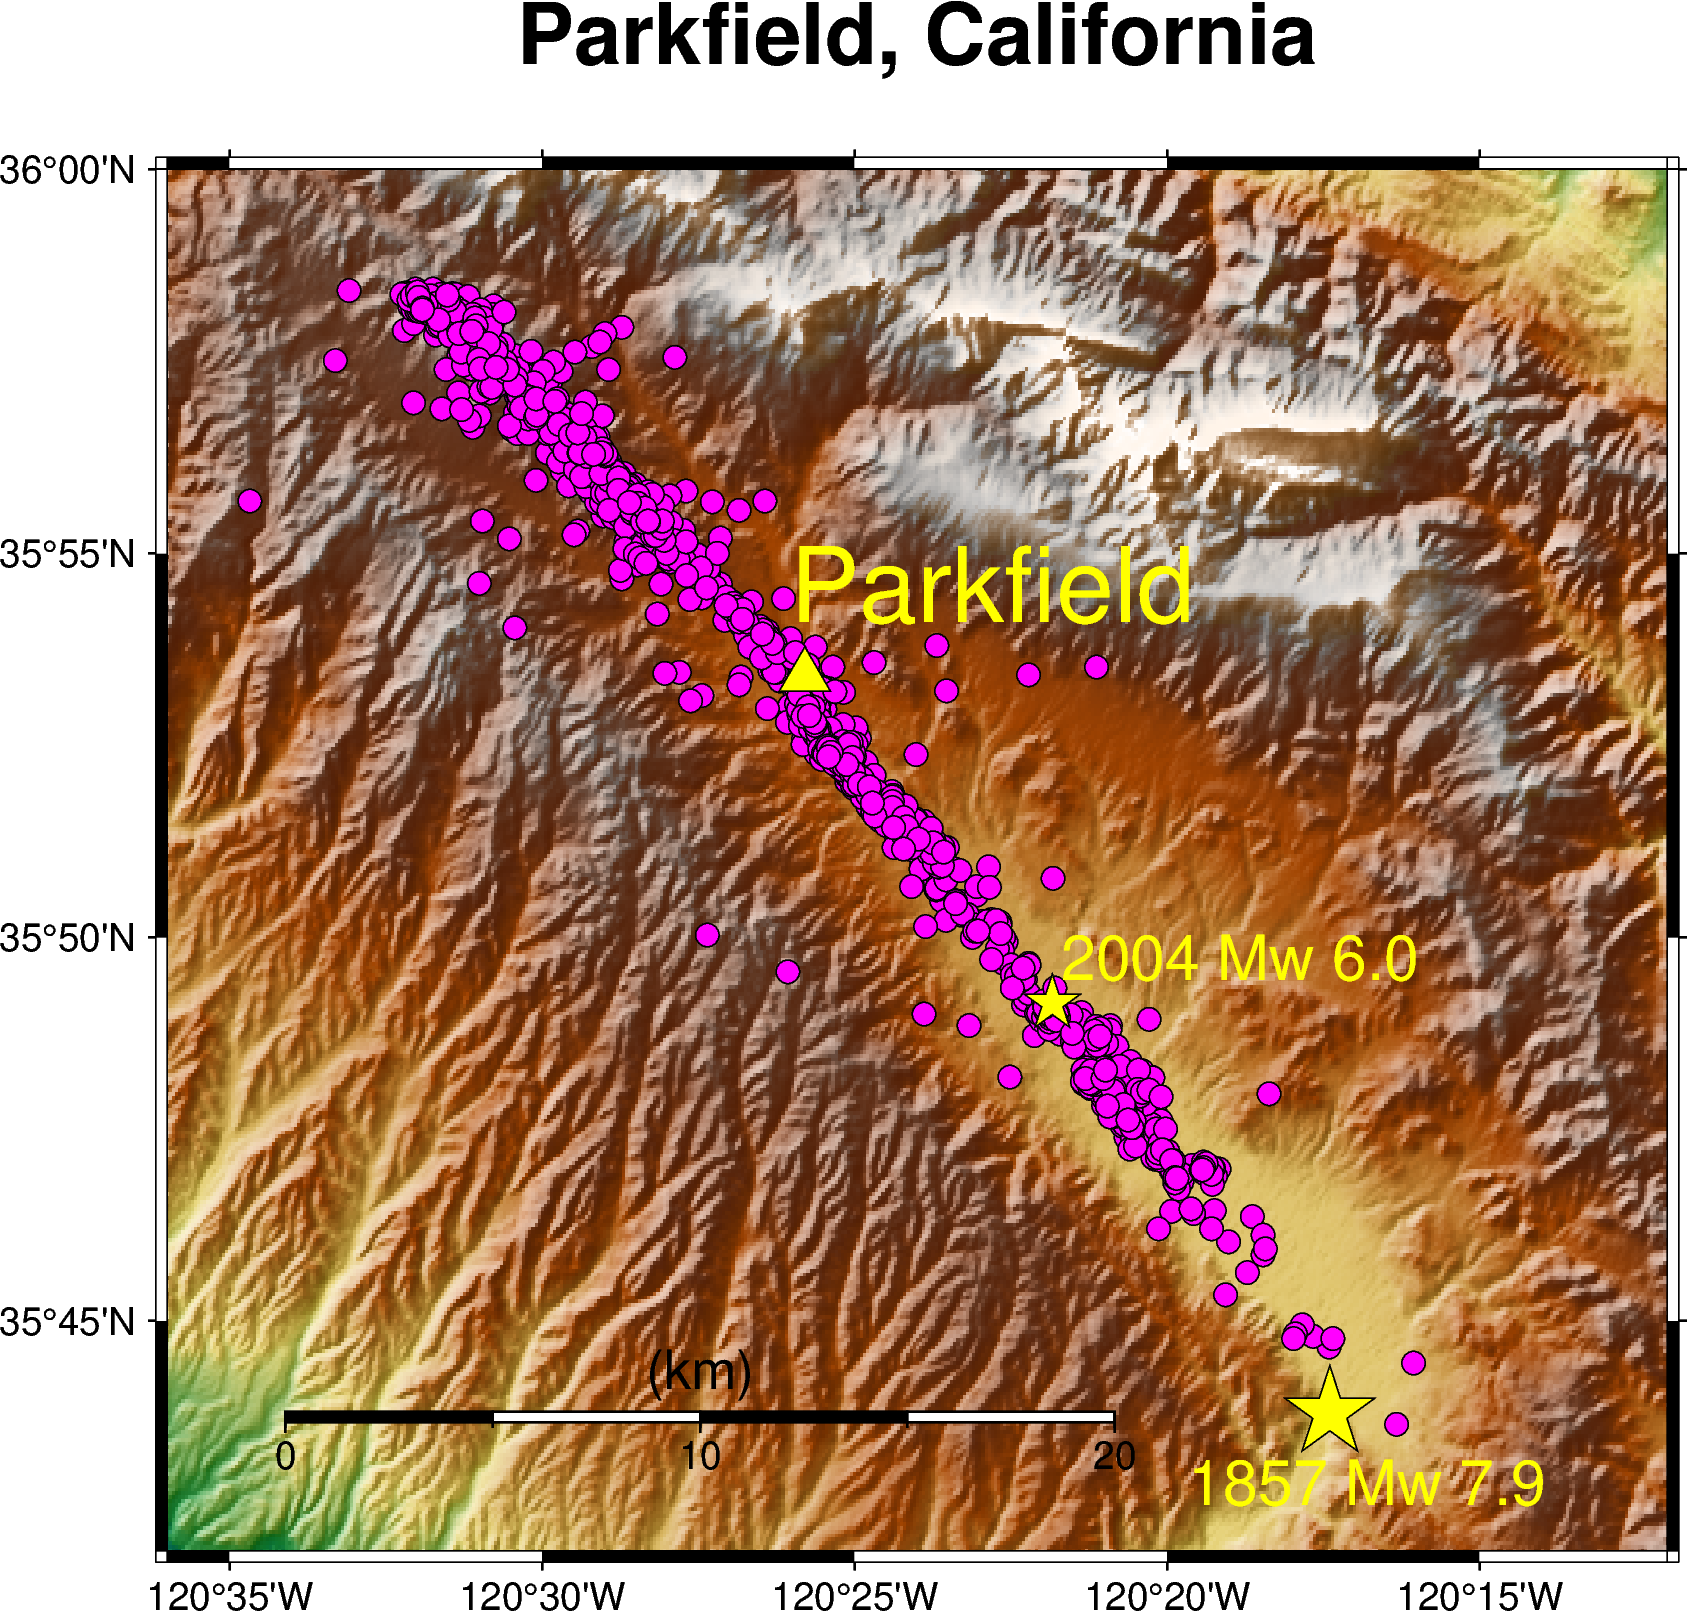

In [548]:
# creates new figure
fig = pygmt.Figure()

# map bounds region
region = [-120.6, -120.2, 35.7, 36.0]

# Parkfield coordinates
park_lon = -120.43
park_lat = 35.89

# 2004 Parkfield 6.0 coordinates
# data from: https://pubs.geoscienceworld.org/ssa/srl/article/76/1/10/143078/Preliminary-Report-on-the-28-September-2004-M-6-0
epi_lon = -120.364
epi_lat = 35.819
epi_depth = 8.8 # km

# retrievs dem data directly from gmt website
fig.grdimage(grid="@earth_relief_03s",region=region,projection="M5i",shading=True) # cmap="geo"

# adds title to map
# fig.basemap(frame=["a", "+tParkfield, California"])
fig.basemap(frame=["a", "+tParkfield, California"])

# plots earthquake epicenters 
fig.plot(x=-west,y=north,style="c0.2c",fill="magenta",pen="black")

# Adding points of interest

# Marks location Parkfield
fig.plot(x=park_lon,y=park_lat,style="t0.5c",fill="yellow",pen="black")

# labels Parkfield / adds text to the location(s) marked above
fig.text(x=park_lon+0.05,y=park_lat+0.02,text="Parkfield",font="25p,Helvetica,yellow")

# Marks location 2004 M 6.0 EQ 
fig.plot(x=epi_lon,y=epi_lat,style="a0.5c",fill="yellow",pen="black")

# labels EQ epicenter / adds text to the location(s) marked above
fig.text(x=epi_lon+0.05,y=epi_lat+0.01,text="2004 Mw 6.0",font="15p,Helvetica,yellow")

# marks approximate location of 1857 M 7.9 EQ (coordinates adjusted from: https://scedc.caltech.edu/earthquake/forttejon1857.html)
fig.plot(x=-120.29,y=35.73,style="a0.8c",fill="yellow",pen="black")

# labels EQ epicenter / adds text to the location(s) marked above
fig.text(x=-120.29+0.01,y=35.73-0.015,text="1857 Mw 7.9",font="15p,Helvetica,yellow")

# adds scale bar
fig.basemap(map_scale="jBL+o1c/1c+w20k+f+l(km)")
# j = from lower right corner, +o1c = 1 cm vertical, /1c = 1 cm horizontal

fig.savefig("Catalog_map_Parkfield.png")

fig.show()

In [370]:
# Next, lets do an inversion for the best fit line through the data...if the strike orientation of the line is identical as the inversion 
# for the best fit plane, then the inversion models agree!

# The best fitting line..in theory, would indicate the SAF fault trace


# From the keeling assignment we did in class:
# this is the inversion format I need to follow

# y = mx + b

# A = [x1 1
#     x2 1
#     xn 1]

# m = [m
#     b]

# d = [y1
#     y2
#     yn]

In [371]:
# Creates the A matrix using x values and ones col

# this creates rows of the data
A_1w = west
A_2w = np.ones(len(A_1))

# now we need to set up the cols of matrix using reshape which will turn rows to cols

A_1w_col = A_1w.reshape(-1,1)
A_2w_col = A_2w.reshape(-1,1)

# horitzontally stacks the cols
Aw = np.hstack((A_1w_col,A_2w_col)) # A Matrix

dy = north

# this will complete the inversion, for a properly set up matrix A
# and vector d...

# construct the normal equations in matrix form
ATAw=np.matmul(Aw.T,Aw)
ATdw=np.matmul(Aw.T,dy)

# invert ATA and multiply that by ATd
mw=np.matmul(np.linalg.inv(ATAw),ATdw) # values of a, b, and c in the plane equation

synth_data=np.matmul(Aw,mw).flatten()

# line equation for reference
# y = mx + b

print('line equation is: y =',mw[0],'x +',mw[1])

line equation is: y = 0.939278423447264 x + -77.23530220181276


In [554]:
# Now that the dip has been calualted, next is to figure out the strike

# So, now I need to figure out the azimuth or angle of the normal vector. Is it dipping to the east...or west...or north...or south

# azumith in rad from the x-axis
strike_rad1 = np.arctan(mw[0])

# azumith in degrees from north, clockwise...solves for strike
strike1 = np.degrees(strike_rad1) % 360

# rounds strike to 3 decimal places
strike_round1 = round(strike1,3)

# OR another way to write strike is N deg W. So you start at North and go X degrees towards West

strike_az1 = 360 - strike1
strike_az_round1 = round(strike_az1,3)

print("Strike (using best fit line method):", strike_az_round1, "deg")

print("Or another way to indicate strike:")

print("Strike (using best fit line method): N",strike_round1,"W")

Strike (using best fit line method): 316.793 deg
Or another way to indicate strike:
Strike (using best fit line method): N 43.207 W


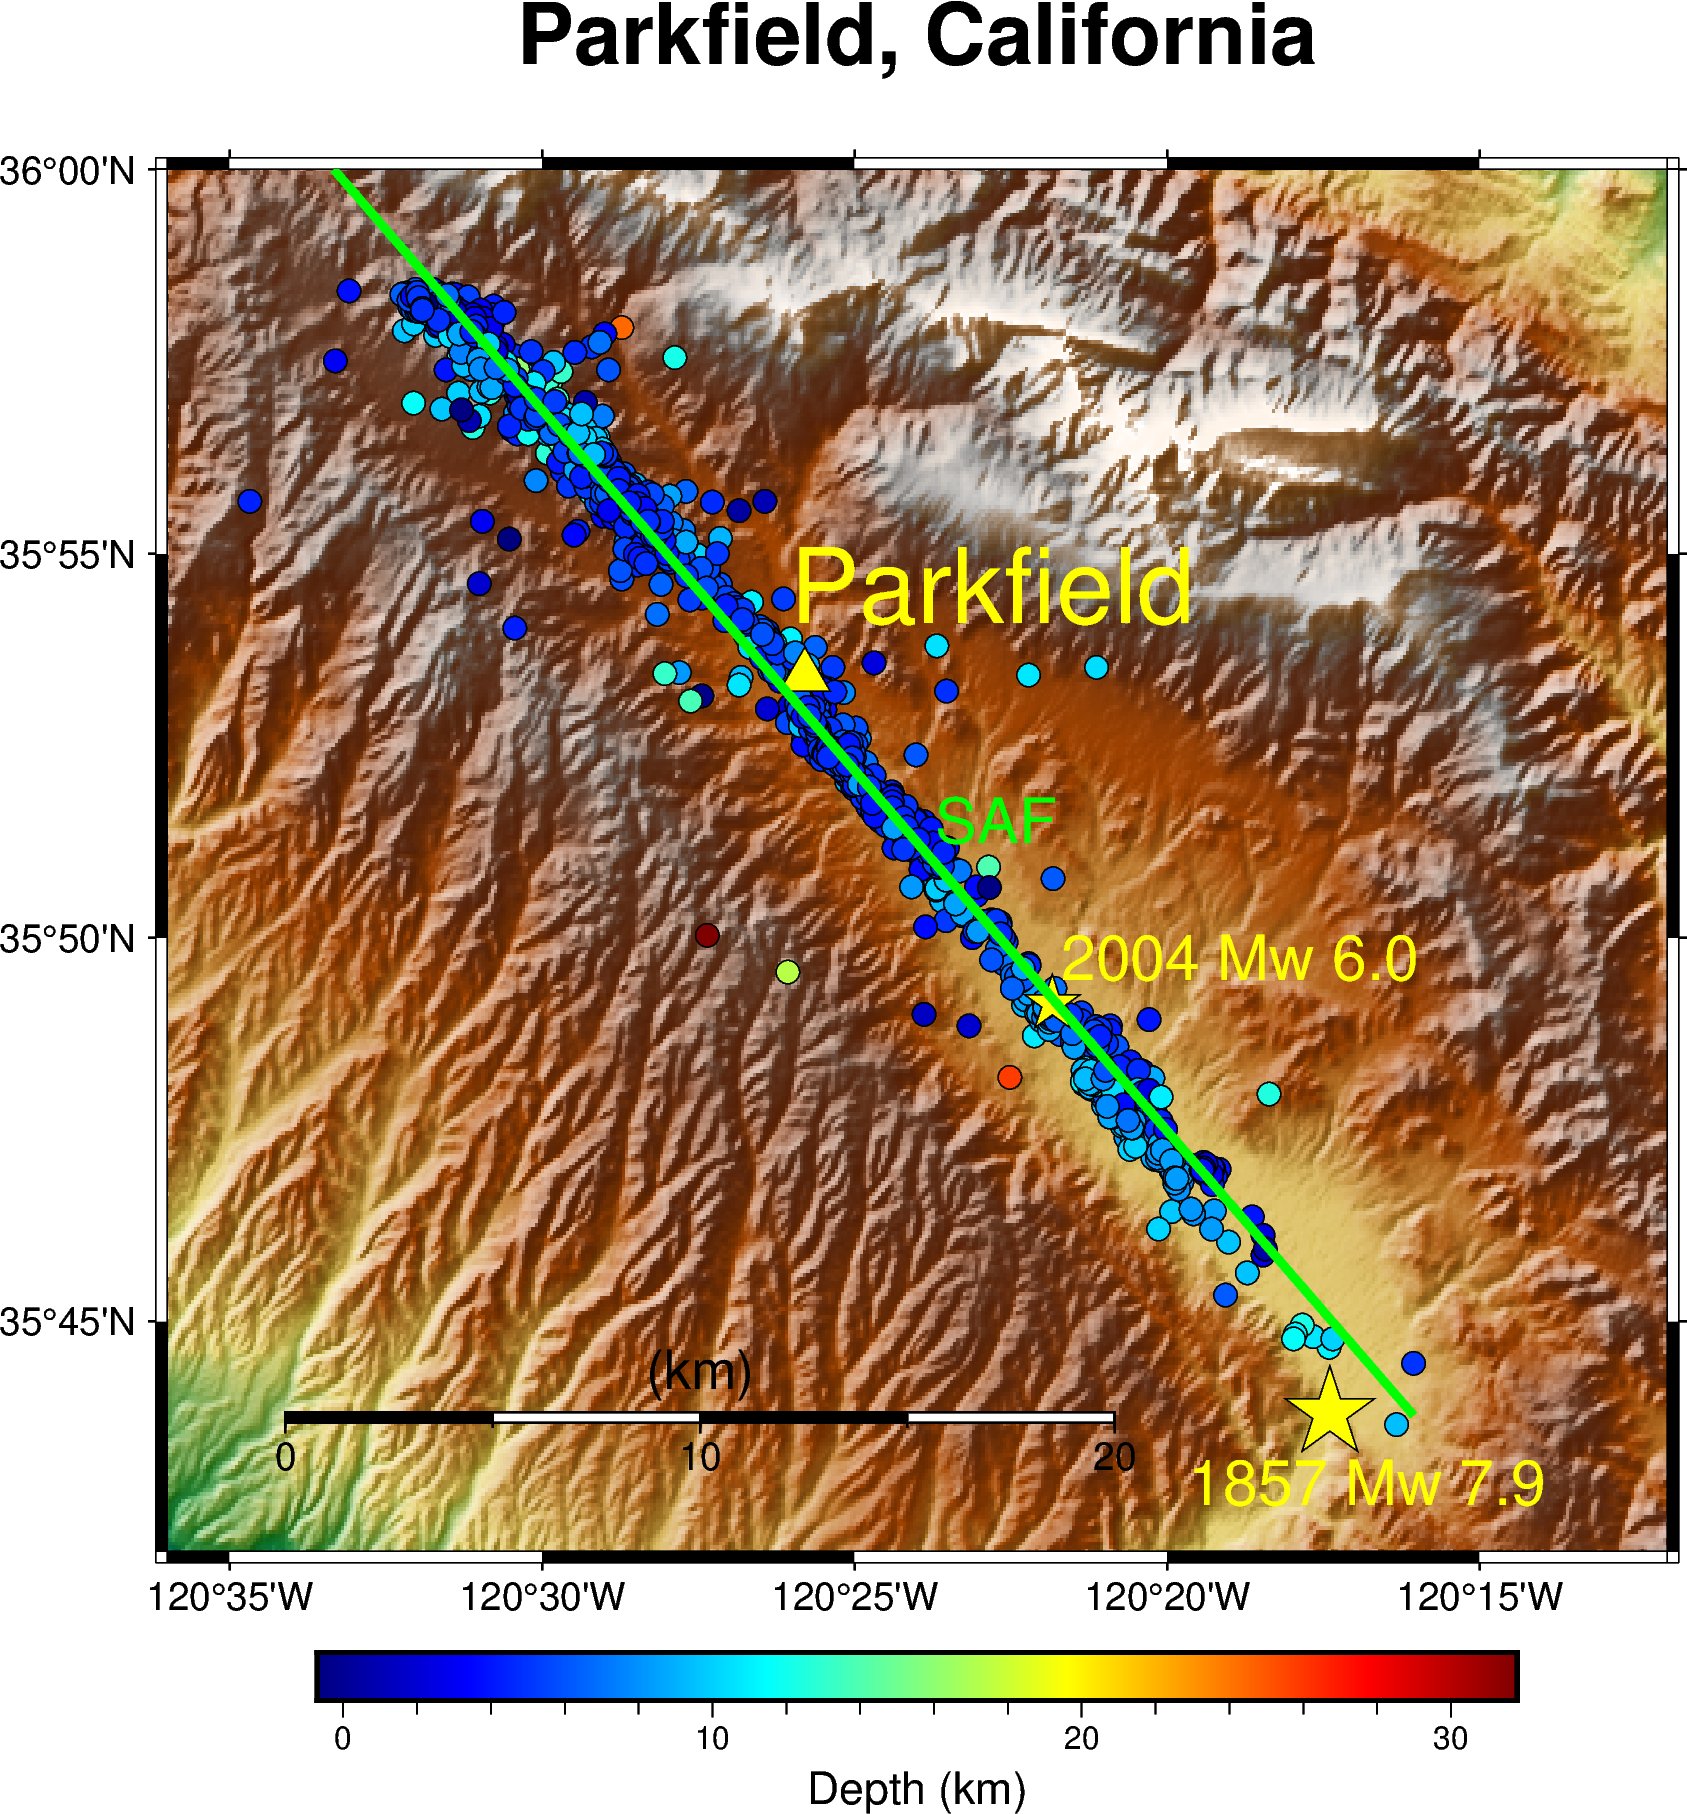

In [547]:
# This adds the best fit line to the figure above

# creates new figure
fig = pygmt.Figure()

# map bounds region
region = [-120.6, -120.2, 35.7, 36.0]

# Parkfield coordinates
park_lon = -120.43
park_lat = 35.89

# 2004 Parkfield 6.0 coordinates
# data from: https://pubs.geoscienceworld.org/ssa/srl/article/76/1/10/143078/Preliminary-Report-on-the-28-September-2004-M-6-0
epi_lon = -120.364
epi_lat = 35.819
epi_depth = 8.8 # km

# retrievs dem data directly from gmt website
#03s is highest resultion
fig.grdimage(grid="@earth_relief_03s",region=region,projection="M5i",shading=True)

# adds title to top of map
fig.basemap(frame=["a", "+tParkfield, California"])

# Adds color scale
pygmt.makecpt(cmap="jet", series=[depth.min(), depth.max()])

# plots earthquake epicenters 
fig.plot(x=-west,y=north,style="c0.2c",fill=depth,pen="black",cmap=True)

# adds colorbar to bottom of map
fig.colorbar(frame='af+lDepth (km)')

# Adding points of interest

# Marks location Parkfield
fig.plot(x=park_lon,y=park_lat,style="t0.5c",fill="yellow",pen="black")

# labels Parkfield / adds text to the location(s) marked above
fig.text(x=park_lon+0.05,y=park_lat+0.02,text="Parkfield",font="25p,Helvetica,yellow")

# Marks location 2004 M 6.0 EQ 
fig.plot(x=epi_lon,y=epi_lat,style="a0.5c",fill="yellow",pen="black")

# labels EQ epicenter / adds text to the location(s) marked above
fig.text(x=epi_lon+0.05,y=epi_lat+0.01,text="2004 Mw 6.0",font="15p,Helvetica,yellow")

# labels SAF
fig.text(x=epi_lon-0.015,y=epi_lat+0.04,text="SAF",font="15p,Helvetica,green")

# adds best fitting line OR SAF fault trace
fig.plot(x=-west,y=synth_data,pen='2p,green')

# marks approximate location of 1857 M 7.9 EQ (coordinates adjusted from: https://scedc.caltech.edu/earthquake/forttejon1857.html)
fig.plot(x=-120.29,y=35.73,style="a0.8c",fill="yellow",pen="black")

# labels EQ epicenter / adds text to the location(s) marked above
fig.text(x=-120.29+0.01,y=35.73-0.015,text="1857 Mw 7.9",font="15p,Helvetica,yellow")

# adds scale bar
fig.basemap(map_scale="jBL+o1c/1c+w20k+f+l(km)")
# j = from lower right corner, +o1c = 1 cm vertical, /1c = 1 cm horizontal

fig.savefig("Best_fit_line_Parkfield.png")


fig.show()

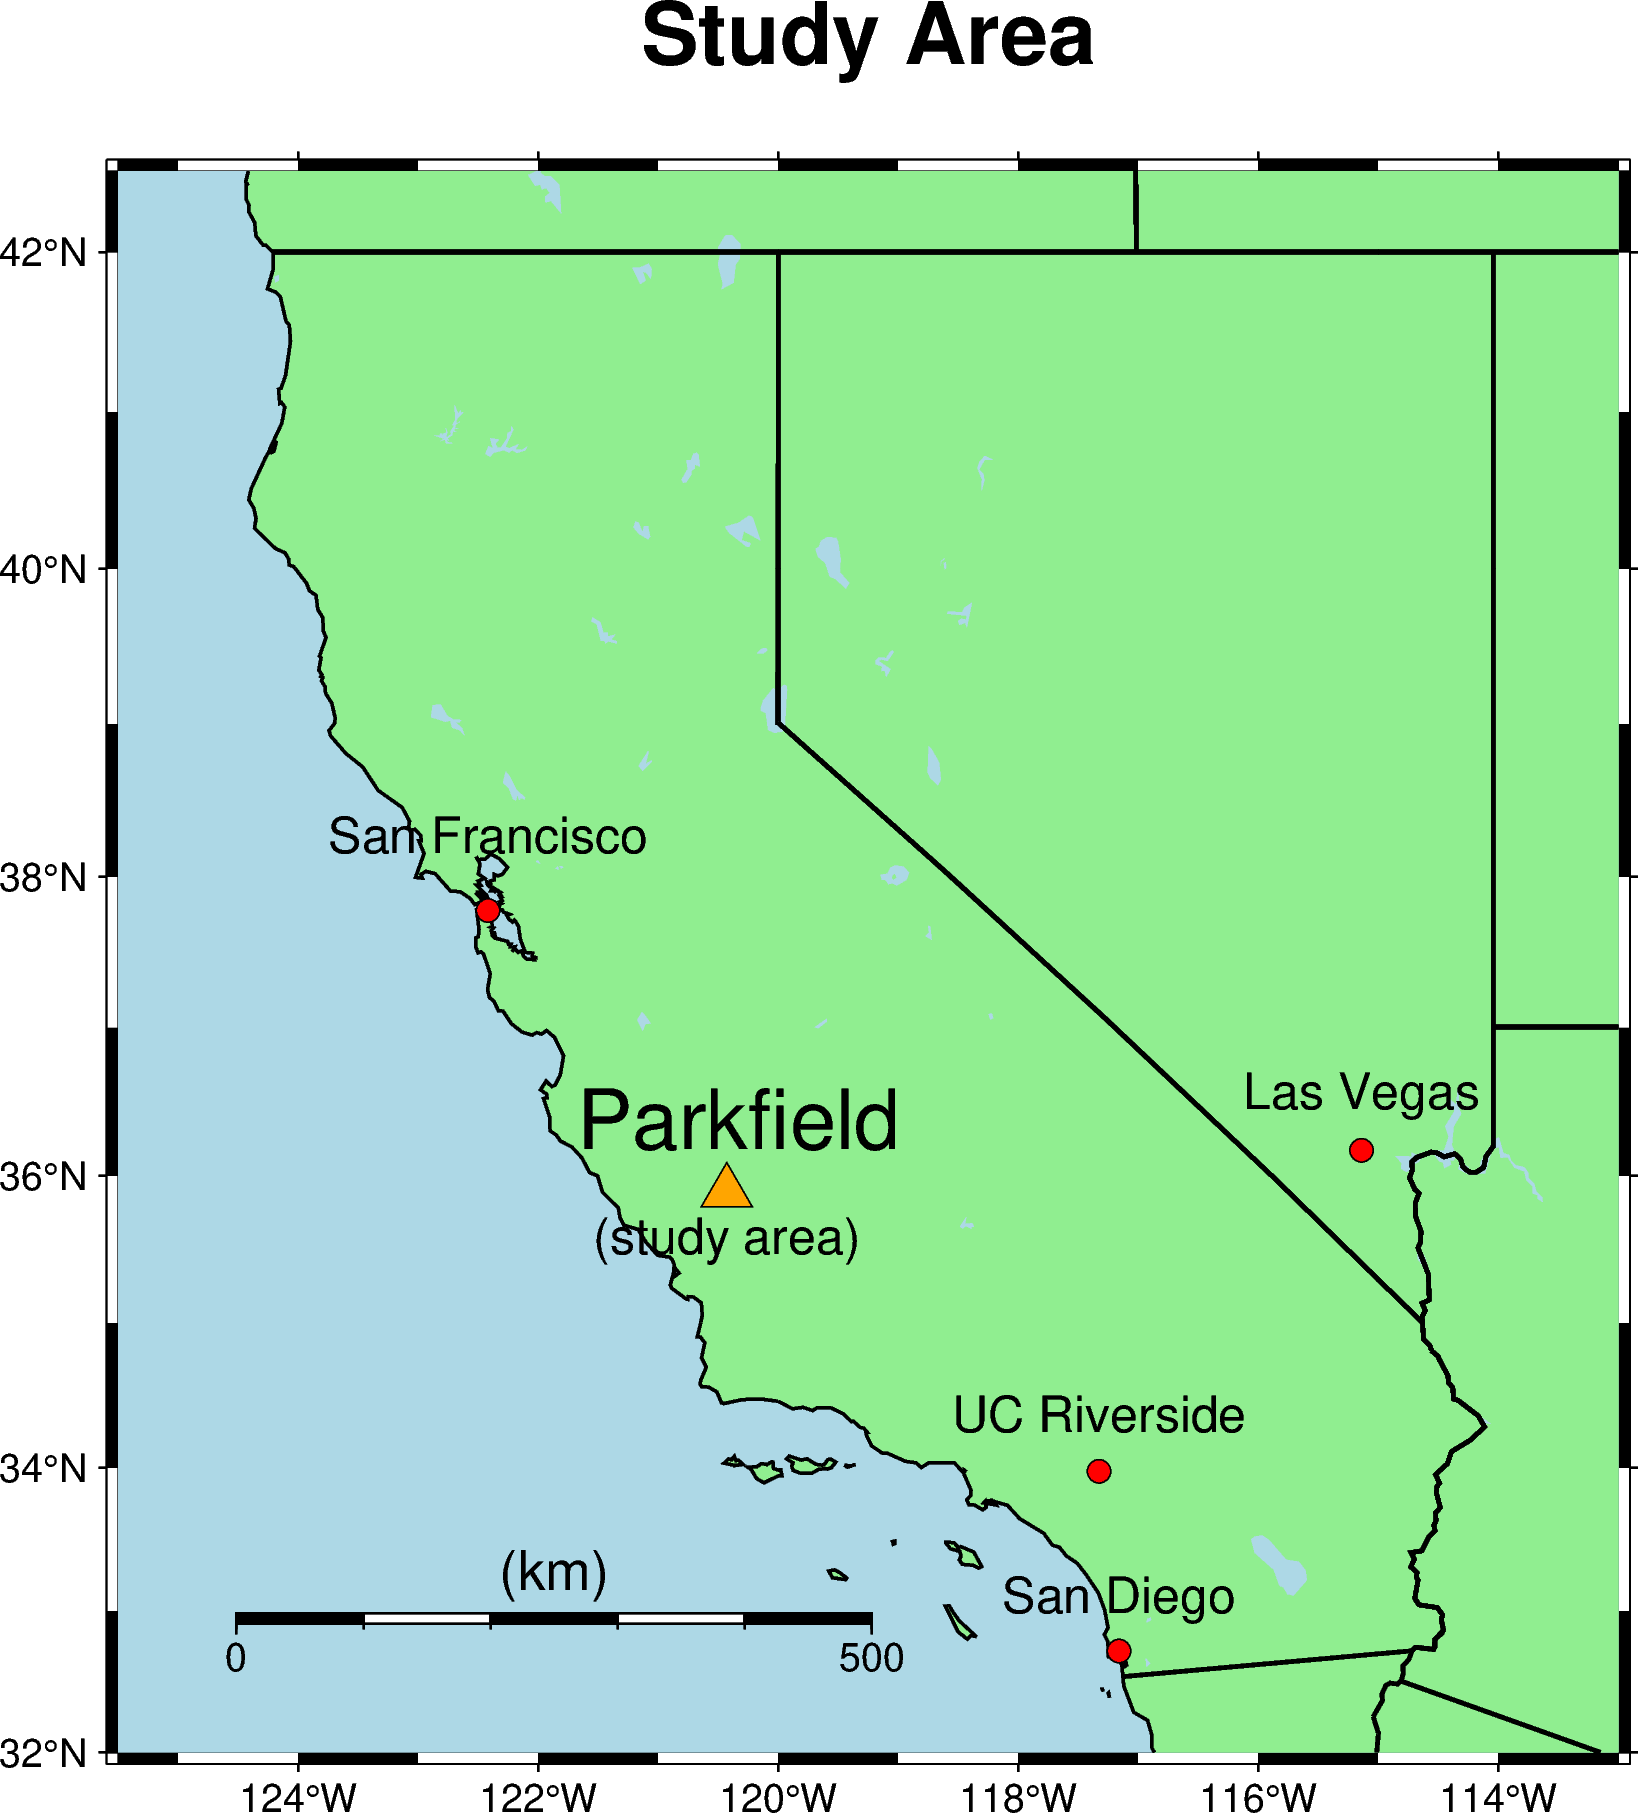

In [551]:
## Study area for reference

# Define region for California
R = [-125.5, -113, 32, 42.5]

fig = pygmt.Figure()

# Base map
fig.basemap(region=R,projection="M5i",frame=["af", "+tStudy Area"])
# mercator projection: M
# 5i map size in inches
# "a" is axis markings (i.e. coordintes along edges)
# "f" is frame ticks
#"+t" is title

# Coastlines
fig.coast(region=R,projection="M5i",land="lightgreen",water="lightblue",shorelines="1/0.75p,black",borders=["1/1p,black", "2/1p,black"])
# mercator projection: M
# 5i map size in inches
# 1 (shorthand for N1) is national borders / pen size, color
# 2 (shorthand for N2) is state borders / pen size, color

# Marks location Parkfield
fig.plot(x=park_lon,y=park_lat,style="t0.5c",fill="orange",pen="black")

# labels Parkfield / adds text to the location(s) marked above
fig.text(x=park_lon+0.1,y=park_lat+0.5,text="Parkfield",font="20p,Helvetica,black")
fig.text(x=park_lon,y=park_lat-0.3,text="(study area)",font="12p,Helvetica,black")

# Marks UCR location (coordinates from google search results)
fig.plot(x=-117.3281,y=33.9737,style="c0.2c",fill="red",pen="black")
fig.text(x=-117.3281,y=33.9737+0.4,text="UC Riverside",font="12p,Helvetica,black")

# some other points of interest (SF, SF, LV) (coordinates from google search results)
fig.plot(x=-122.4194,y=37.7749,style="c0.2c",fill="red",pen="black")
fig.text(x=-122.4194,y=37.7749+0.5,text="San Francisco",font="12p,Helvetica,black")

fig.plot(x=-117.1611,y=32.7157,style="c0.2c",fill="red",pen="black")
fig.text(x=-117.1611,y=32.7157+0.4,text="San Diego",font="12p,Helvetica,black")

fig.plot(x=-115.1391,y=36.1716,style="c0.2c",fill="red",pen="black")
fig.text(x=-115.1391,y=36.1716+0.4,text="Las Vegas",font="12p,Helvetica,black")

# adds scale bar
fig.basemap(map_scale="jBL+o1c/1c+w500k+f+l(km)")
# j = from lower right corner, +o1c = 1 cm vertical, /1c = 1 cm horizontal


fig.savefig("California_map.png")

fig.show()